In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from torchinfo import summary
from fvcore.nn import FlopCountAnalysis
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from lightning.pytorch import seed_everything
import lightning as L
import torch
import seaborn as sns
import numpy as np
import json
import argparse
import matplotlib.pyplot as plt
import scienceplots
import os
from model_modules import *
from data_modules import *
import torch.nn.functional as F
# from ablation import *

plt.style.use('science')

In [3]:
def load_ckpt(model_class, run_name, file_name):
    ckpt_path = os.path.join("Satelite-Interference",
                             run_name, "checkpoints", file_name)
    model = model_class.load_from_checkpoint(ckpt_path)
    return model


models = [
    [CDMA_Net, "gjoxavfa", "cdma_epoch=430-step=38790-val_loss=0.00.ckpt"],
    [CNNAEAttention, "p3fky56w", "cnn_ae_att_epoch=208-step=18810-val_loss=0.03.ckpt"],
    [LinearAE, "qnz17vpr", "linear_ae_epoch=103-step=9360-val_loss=0.02.ckpt"],
    # [LinearVAE, "bkvapq2t", "linear_vae_epoch=386-step=34830-val_loss=0.02.ckpt"],
    [CNNAE, "wtgwzqaa", "cnn_ae_epoch=115-step=10440-val_loss=0.02.ckpt"],
    # [CNNVAE, "dqho97xp", "cnn_vae_epoch=223-step=20160-val_acc=0.02.ckpt"],
    [TransformerAE, "ish762qv", "transformer_ae_epoch=320-step=28890-val_acc=0.00.ckpt"],
    [TransformerAE, "e4didim2", "transformer_ae_epoch=86-step=7830-val_loss=0.00.ckpt"],
    # [TransformerVAE, "qxmwpa49", "transformer_vae_epoch=235-step=21240-val_acc=0.03.ckpt"],
]

In [4]:
data_module = BaseDataModule(batch_size=128)
data_module.prepare_data()
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()
print(test_loader)

In [5]:
def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
def test_model(model, test_loader):
    model.eval()
    reconstruction_errors = []
    wavelet_errors = []  # Store wavelet components separately
    all_true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            signal = batch['signal'].to(model.device)
            spectrum = batch['spectrum'].to(model.device)
            labels = batch['label'].cpu().numpy()
            target = torch.cat([signal, spectrum], dim=1)

            # Get reconstructions based on model type
            if isinstance(model, AE):
                recon_signal, recon_spectrum = model(signal, spectrum)
                if (len(recon_signal.shape) == 2):
                    recon_signal = recon_signal.unsqueeze(1)
                if (len(recon_spectrum.shape) == 2):
                    recon_spectrum = recon_spectrum.unsqueeze(1)
                recon = torch.cat([recon_signal, recon_spectrum], dim=1)
            elif isinstance(model, VAE):
                recon_signal, recon_spectrum, _, _ = model(signal, spectrum)
                recon = torch.cat([recon_signal, recon_spectrum], dim=1)
            elif isinstance(model, CDMA_Net):
                recon = model(signal, spectrum)
            else:
                raise ValueError(f"Unsupported model type: {type(model)}")

            # Universal base error calculation
            mse_error = F.mse_loss(recon, target, reduction='none')
            mse_per_sample = mse_error.mean(dim=[1, 2]).cpu().numpy()  # [B]

            if isinstance(model, CDMA_Net):
                # Calculate wavelet components for CDMA specifically
                wave_recon = model._wavelet_transform(recon)
                wave_target = model._wavelet_transform(target)

                # Match model's original training loss formula
                wave_loss = F.mse_loss(
                    wave_recon, wave_target, reduction='none')
                wave_per_sample = 0.5 * \
                    wave_loss.mean(dim=[1, 2, 3]).cpu().numpy()  # [B]

                total_error = mse_per_sample + wave_per_sample
                wavelet_errors.extend(wave_per_sample)  # Store for analysis
            else:
                total_error = mse_per_sample  # Original behavior for other models

            reconstruction_errors.extend(total_error)
            all_true_labels.extend(labels)

    reconstruction_errors = np.array(reconstruction_errors)
    all_true_labels = np.array(all_true_labels)

    # Compute beta_0 using test errors instead of training errors
    mean_test_error = np.mean(reconstruction_errors)
    std_test_error = np.std(reconstruction_errors)
    print(f"{model.__class__.__name__} - Mean test error: {mean_test_error:.4f}, Std test error: {std_test_error:.4f}")
    # threshold = mean_test_error + 5 * std_test_error
    threshold = np.percentile(reconstruction_errors, 50)

    # Predict based on the new threshold
    predicted_labels = (reconstruction_errors > threshold).astype(int)

    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(all_true_labels, reconstruction_errors)
    roc_auc_val = auc(fpr, tpr)

    num_params = count_parameters(model)

    return {
        'reconstruction_errors': reconstruction_errors,
        'predicted_labels': predicted_labels,
        'threshold': threshold,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc_val,
        'confusion_matrix': confusion_matrix(all_true_labels, predicted_labels),
        'classification_report': classification_report(all_true_labels, predicted_labels,
                                                       target_names=['Interference-free', 'Interference'], digits=6),
        'num_params': num_params
    }

In [7]:
import pickle
import os
import numpy as np

results = {}
for model_class, run_name, file_name in models:
    model = load_ckpt(model_class, run_name, file_name)
    results[model.__class__.__name__] = test_model(model, test_loader)

    filename = os.path.join(
        'results', f"{model.__class__.__name__}_results.pkl")
    with open(filename, 'wb') as f:
        pickle.dump({
            'name': model.__class__.__name__,
            'fpr': results[model.__class__.__name__]['fpr'],
            'tpr': results[model.__class__.__name__]['tpr'],
            'roc_auc': results[model.__class__.__name__]['roc_auc'],
            'threshold': results[model.__class__.__name__]['threshold'],
        }, f)

CDMA_Net - Mean test error: 0.0048, Std test error: 0.1144
CNNAEAttention - Mean test error: 0.0201, Std test error: 0.0477
LinearAE - Mean test error: 0.0165, Std test error: 0.0855
CNNAE - Mean test error: 0.0132, Std test error: 0.0315


/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerAE - Mean test error: 0.0053, Std test error: 0.0491


/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerAE - Mean test error: 0.0072, Std test error: 0.0604


CDMA_Net - AUC: 0.9327
CNNAEAttention - AUC: 0.8719
LinearAE - AUC: 0.9176
CNNAE - AUC: 0.9175
TransformerAE - AUC: 0.6812


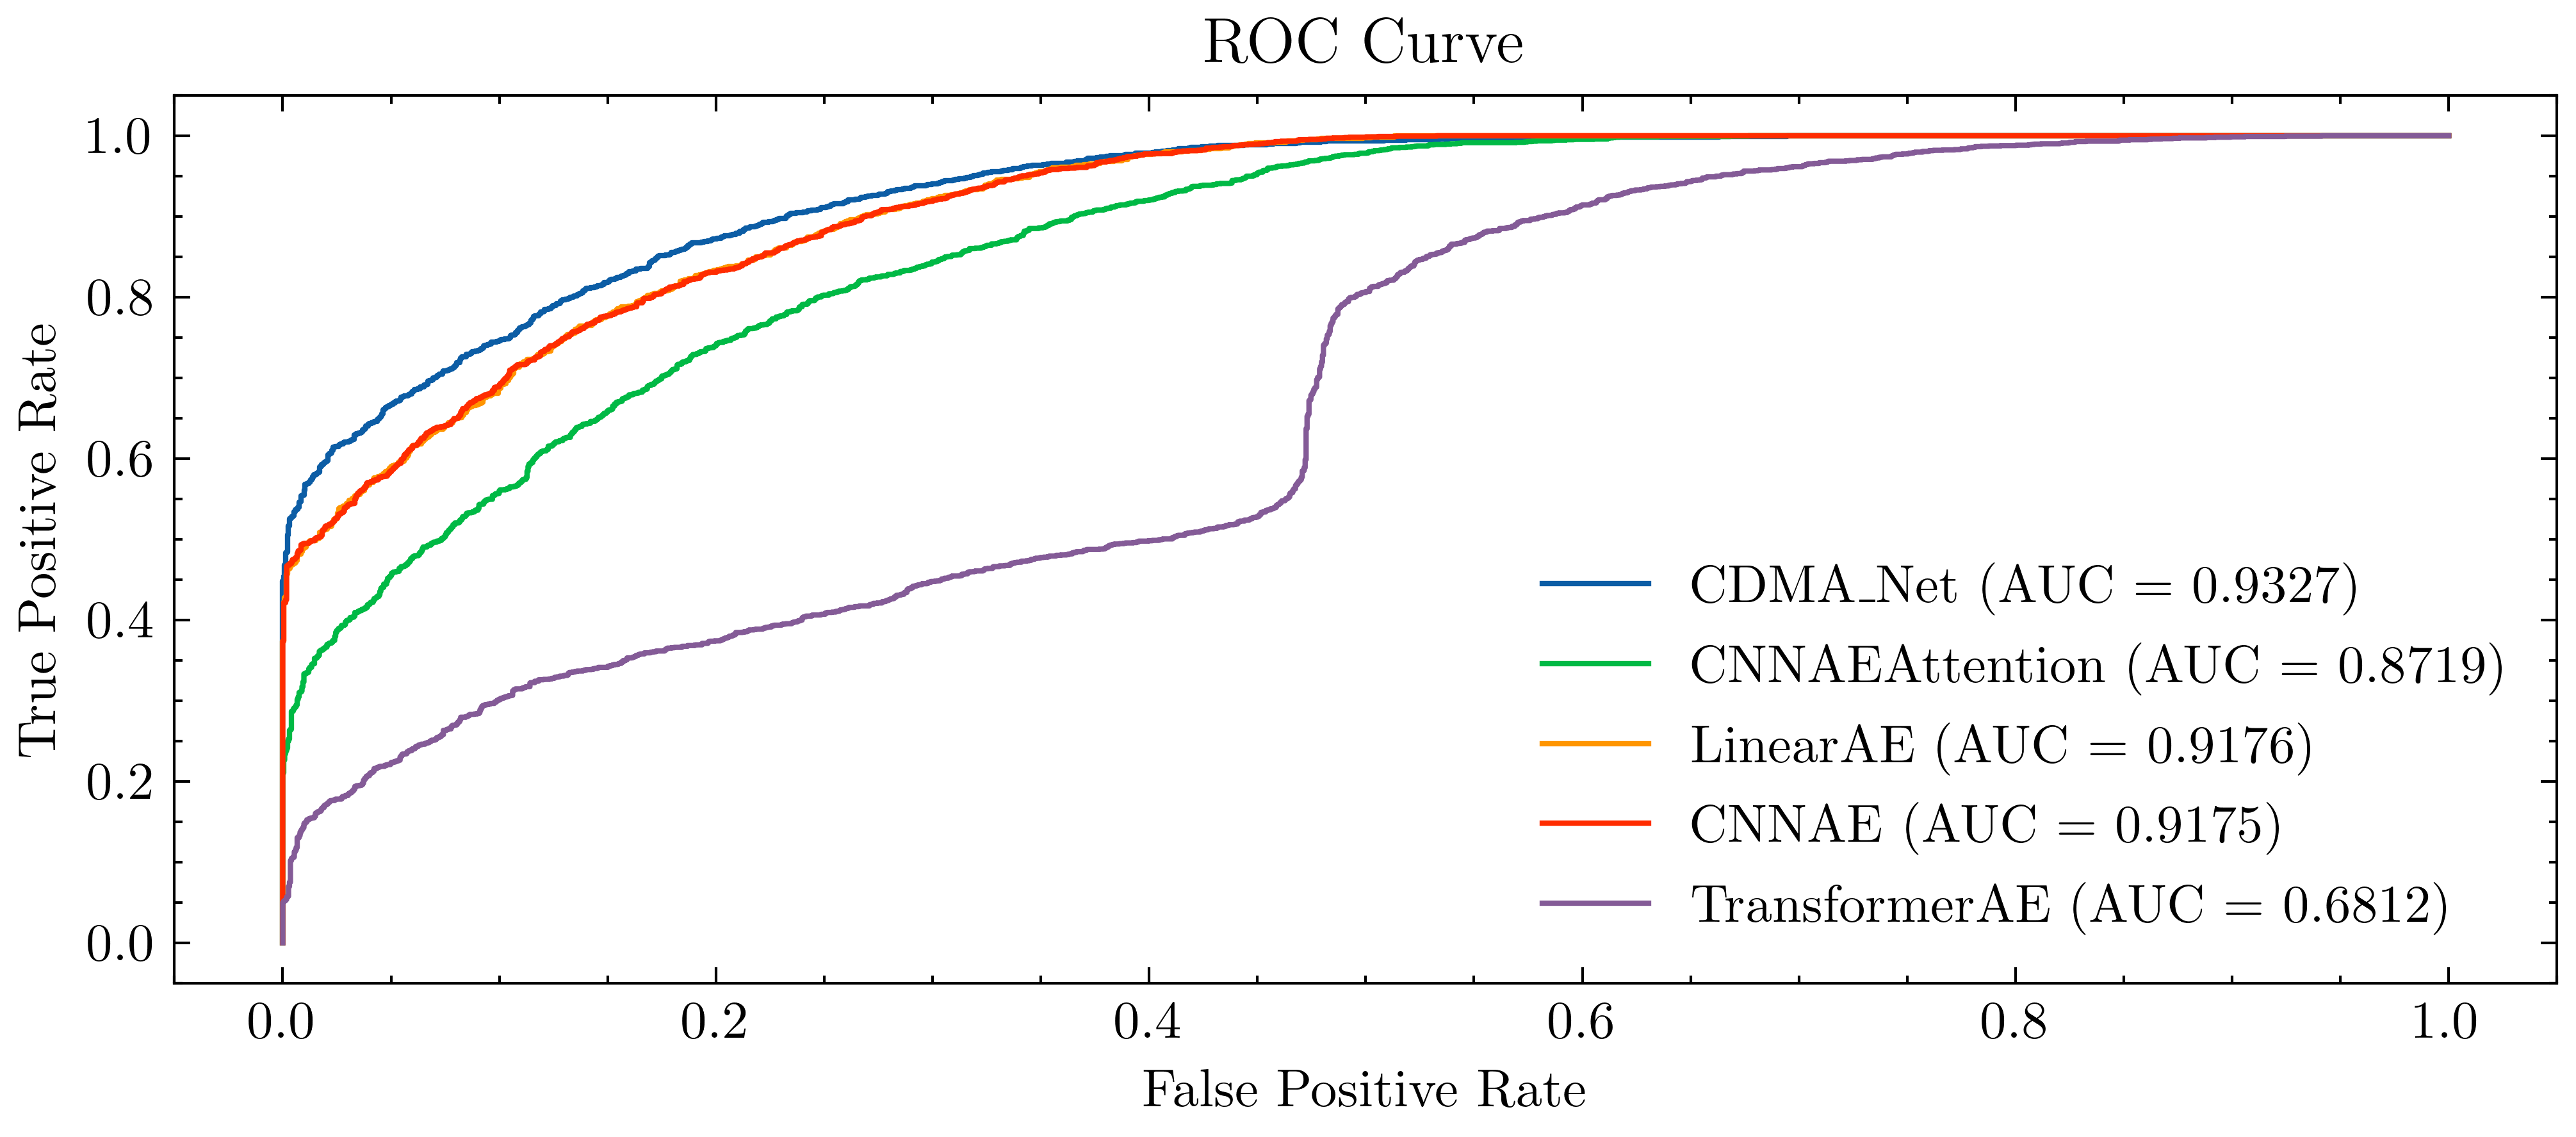

In [8]:
def plot_comparative_roc(results):
    """Plot ROC curve for CNN model"""
    plt.figure(figsize=(8, 3), dpi=600)
    for model_name, metrics in results.items():
        print(f"{model_name} - AUC: {metrics['roc_auc']:.4f}")
        plt.plot(metrics['fpr'], metrics['tpr'],
                 label=f'{model_name} (AUC = {metrics["roc_auc"]:.4f})')

    # plt.plot([0, 1], [0, 1], color='navy', lw=2,
        #  linestyle='--', label='Random Guess')
    # plt.xlim([-0.01, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    # plt.grid(True)
    # plt.show()
    plt.savefig("doc/images/roc.pdf")


plot_comparative_roc(results)

In [9]:
for model_name, metrics in results.items():
    print(f"Model: {model_name}, auc: {metrics['roc_auc']}, params: {metrics['num_params']}")
    print(f"{metrics['classification_report']}")

Model: CDMA_Net, auc: 0.9326704085898196, params: 212068
                   precision    recall  f1-score   support

Interference-free   0.837584  0.831261  0.834411      2252
     Interference   0.829978  0.836339  0.833146      2218

         accuracy                       0.833781      4470
        macro avg   0.833781  0.833800  0.833778      4470
     weighted avg   0.833810  0.833781  0.833783      4470

Model: CNNAEAttention, auc: 0.8718640238833892, params: 85026
                   precision    recall  f1-score   support

Interference-free   0.777181  0.771314  0.774237      2252
     Interference   0.769575  0.775473  0.772513      2218

         accuracy                       0.773378      4470
        macro avg   0.773378  0.773394  0.773375      4470
     weighted avg   0.773407  0.773378  0.773381      4470

Model: LinearAE, auc: 0.9175516963580714, params: 4200384
                   precision    recall  f1-score   support

Interference-free   0.821924  0.815719  0.818810 

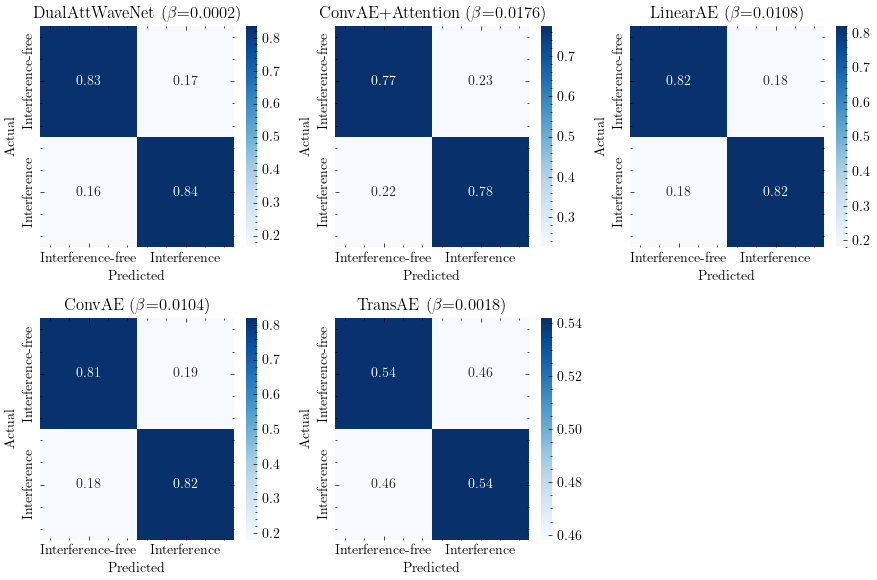

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_comparative_confusion_matrices(results, normalize=True):
    """Plot normalized confusion matrices for CNN model."""
    num_models = len(results)
    fig, axes = plt.subplots(2, 3, figsize=(9, 6))  # 2x3 grid

    # Flatten axes for easy iteration
    axes = axes.flatten()

    for ax, (model_name, metrics) in zip(axes, results.items()):
        if model_name == "CDMA_Net":
            model_name = "DualAttWaveNet"
        elif model_name == "CNNAE":
            model_name = "ConvAE"
        elif model_name == "CNNAEAttention":
            model_name = "ConvAE+Attention"
        elif model_name == "TransformerAE":
            model_name = "TransAE"

        cm = metrics['confusion_matrix']

        if normalize:
            # Normalize by row (true class)
            cm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

        sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap='Blues',
                    xticklabels=['Interference-free', 'Interference'],
                    yticklabels=['Interference-free', 'Interference'], ax=ax)

        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{model_name} ($\\beta$={metrics["threshold"]:.4f})')
        ax.xaxis.set_tick_params(rotation=0)

    # Hide unused subplots
    for i in range(num_models, 6):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("doc/images/confusion.pdf", bbox_inches='tight', dpi=600)


# Example usage:
plot_comparative_confusion_matrices(results)

# Collect reconstruction samples

In [11]:
import os
import pickle
import torch
import numpy as np


def collect_reconstruction_data(model, test_loader):
    """Collect input/output pairs for one sample of each label (0 and 1)"""
    model.eval()
    samples = {
        '0_time_in': None, '0_time_out': None,
        '0_freq_in': None, '0_freq_out': None,
        '1_time_in': None, '1_time_out': None,
        '1_freq_in': None, '1_freq_out': None
    }

    with torch.no_grad():
        for batch in test_loader:
            # Check if we have both samples
            if all(v is not None for v in samples.values()):
                break

            signal = batch['signal'].to(model.device)
            spectrum = batch['spectrum'].to(model.device)
            labels = batch['label'].numpy()

            # Get reconstructions
            if isinstance(model, AE):
                recon_signal, recon_spectrum = model(signal, spectrum)
                recon = torch.cat([recon_signal.unsqueeze(
                    1), recon_spectrum.unsqueeze(1)], dim=1)
            elif isinstance(model, VAE):
                recon_signal, recon_spectrum, _, _ = model(signal, spectrum)
                recon = torch.cat([recon_signal, recon_spectrum], dim=1)
            elif isinstance(model, CDMA_Net):
                recon = model(signal, spectrum)

            # Convert to numpy arrays
            signal_np = signal.squeeze(1).cpu().numpy()  # [B, seq_len]
            spectrum_np = spectrum.squeeze(1).cpu().numpy()
            time_out = recon[:, 0].cpu().numpy()
            freq_out = recon[:, 1].cpu().numpy()

            # Collect first sample of each label type
            for i in range(20, len(labels)):
                label = int(labels[i])
                prefix = str(label)

                if samples[f'{prefix}_time_in'] is None:
                    samples.update({
                        # Flatten to array for easier plotting
                        f'{prefix}_time_in': signal_np[i].flatten(),
                        f'{prefix}_freq_in': spectrum_np[i].flatten(),
                        f'{prefix}_time_out': time_out[i].flatten(),
                        f'{prefix}_freq_out': freq_out[i].flatten()
                    })

                if all(samples[k] is not None for k in samples if k.startswith('0_')):
                    if all(samples[k] is not None for k in samples if k.startswith('1_')):
                        break

    return samples


# Create results directory
os.makedirs('results', exist_ok=True)

results = {}
for model_class, run_name, file_name in models:
    model = load_ckpt(model_class, run_name, file_name)

    # Collect reconstruction data
    recon_data = collect_reconstruction_data(model, test_loader)

    # Save directly to pickle
    class_name = model.__class__.__name__
    filename = f'results/{class_name}_recon.pkl'
    print(f"Saving reconstruction data for {class_name}, data = {recon_data}")

    with open(filename, 'wb') as f:
        pickle.dump(recon_data, f)

    print(f"Saved reconstruction data for {class_name} to {filename}")

Saving reconstruction data for CDMA_Net, data = {'0_time_in': array([0.13012439, 0.07772086, 0.06275378, 0.12106352, 0.13454422,
       0.26969993, 0.13064331, 0.2597038 , 0.46780354, 0.38828328,
       0.13189636, 0.53722924, 0.6110809 , 0.11759385, 0.53315073,
       0.39096493, 0.63822526, 0.32414165, 0.15882128, 0.1315196 ,
       0.4965978 , 0.35089794, 0.32582045, 0.17820658, 0.33539733,
       0.04729546, 0.2718769 , 0.2832241 , 0.41248152, 0.40614498,
       0.61279625, 0.25732002, 0.6485421 , 0.544248  , 0.605713  ,
       0.10887954, 0.5612991 , 0.39094377, 0.3238726 , 0.07729281,
       0.49633965, 0.65175635, 0.4984162 , 0.20923859, 0.31667352,
       0.38836446, 0.6330159 , 0.44695643, 0.52610165, 0.15612641,
       0.1959796 , 0.3046388 , 0.5087683 , 0.05624355, 0.66047287,
       0.375033  , 0.13608392, 0.21704905, 0.4848224 , 0.43138537,
       0.41009715, 0.42162272, 0.20081428, 0.02363843, 0.18877743,
       0.27916375, 0.6345619 , 0.36974064, 0.22439697, 0.46947008,


/home/castle/miniconda3/envs/cu126/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Saving reconstruction data for TransformerAE, data = {'0_time_in': array([0.13012439, 0.07772086, 0.06275378, 0.12106352, 0.13454422,
       0.26969993, 0.13064331, 0.2597038 , 0.46780354, 0.38828328,
       0.13189636, 0.53722924, 0.6110809 , 0.11759385, 0.53315073,
       0.39096493, 0.63822526, 0.32414165, 0.15882128, 0.1315196 ,
       0.4965978 , 0.35089794, 0.32582045, 0.17820658, 0.33539733,
       0.04729546, 0.2718769 , 0.2832241 , 0.41248152, 0.40614498,
       0.61279625, 0.25732002, 0.6485421 , 0.544248  , 0.605713  ,
       0.10887954, 0.5612991 , 0.39094377, 0.3238726 , 0.07729281,
       0.49633965, 0.65175635, 0.4984162 , 0.20923859, 0.31667352,
       0.38836446, 0.6330159 , 0.44695643, 0.52610165, 0.15612641,
       0.1959796 , 0.3046388 , 0.5087683 , 0.05624355, 0.66047287,
       0.375033  , 0.13608392, 0.21704905, 0.4848224 , 0.43138537,
       0.41009715, 0.42162272, 0.20081428, 0.02363843, 0.18877743,
       0.27916375, 0.6345619 , 0.36974064, 0.22439697, 0.46947

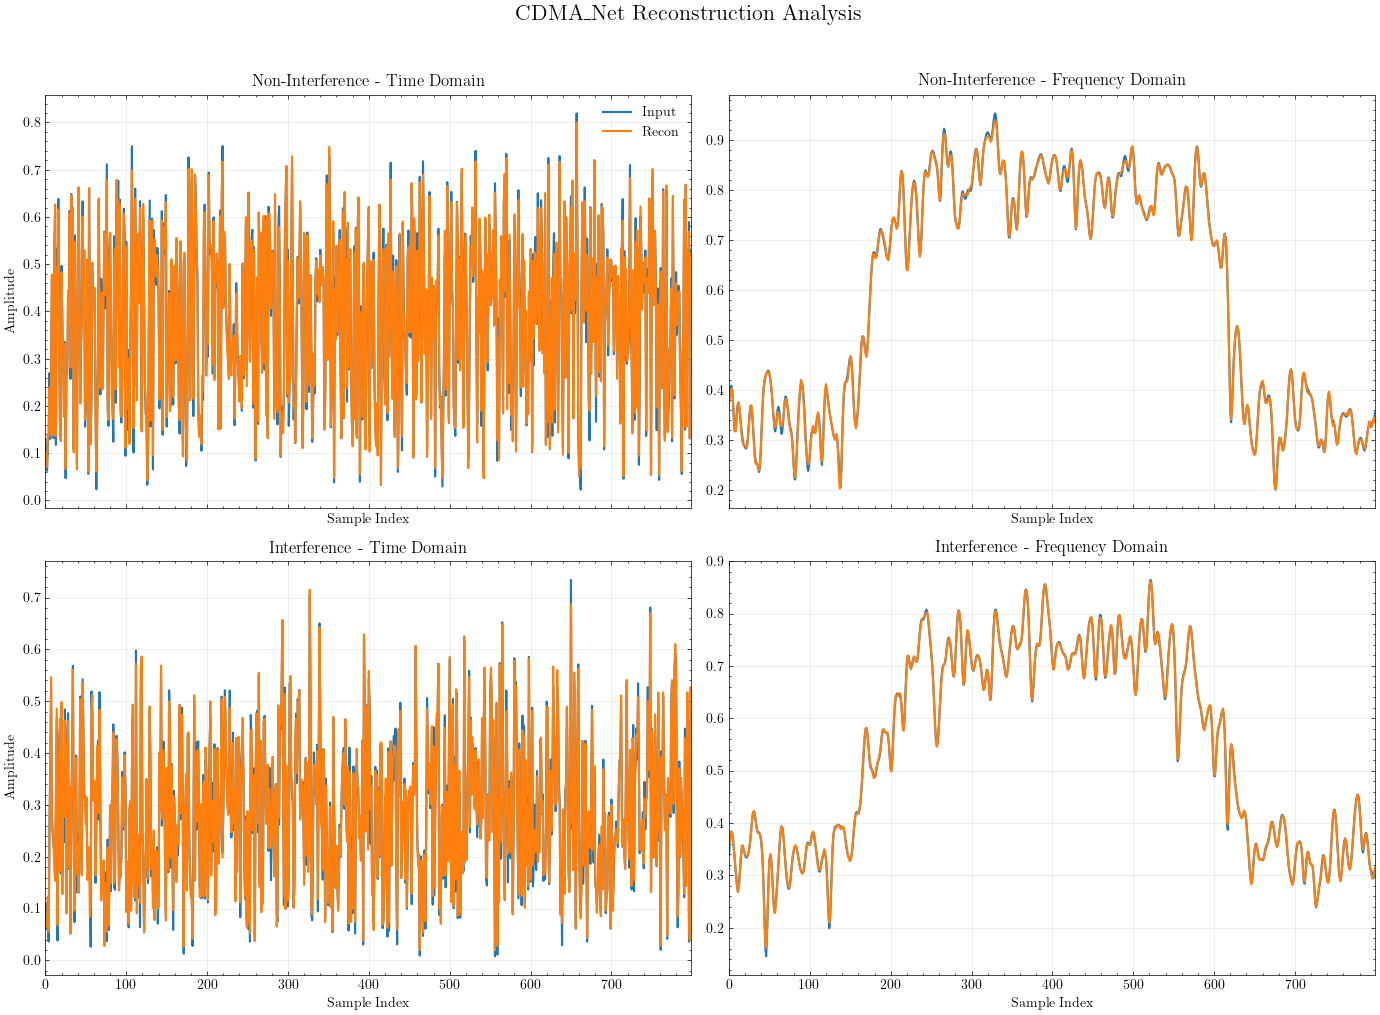

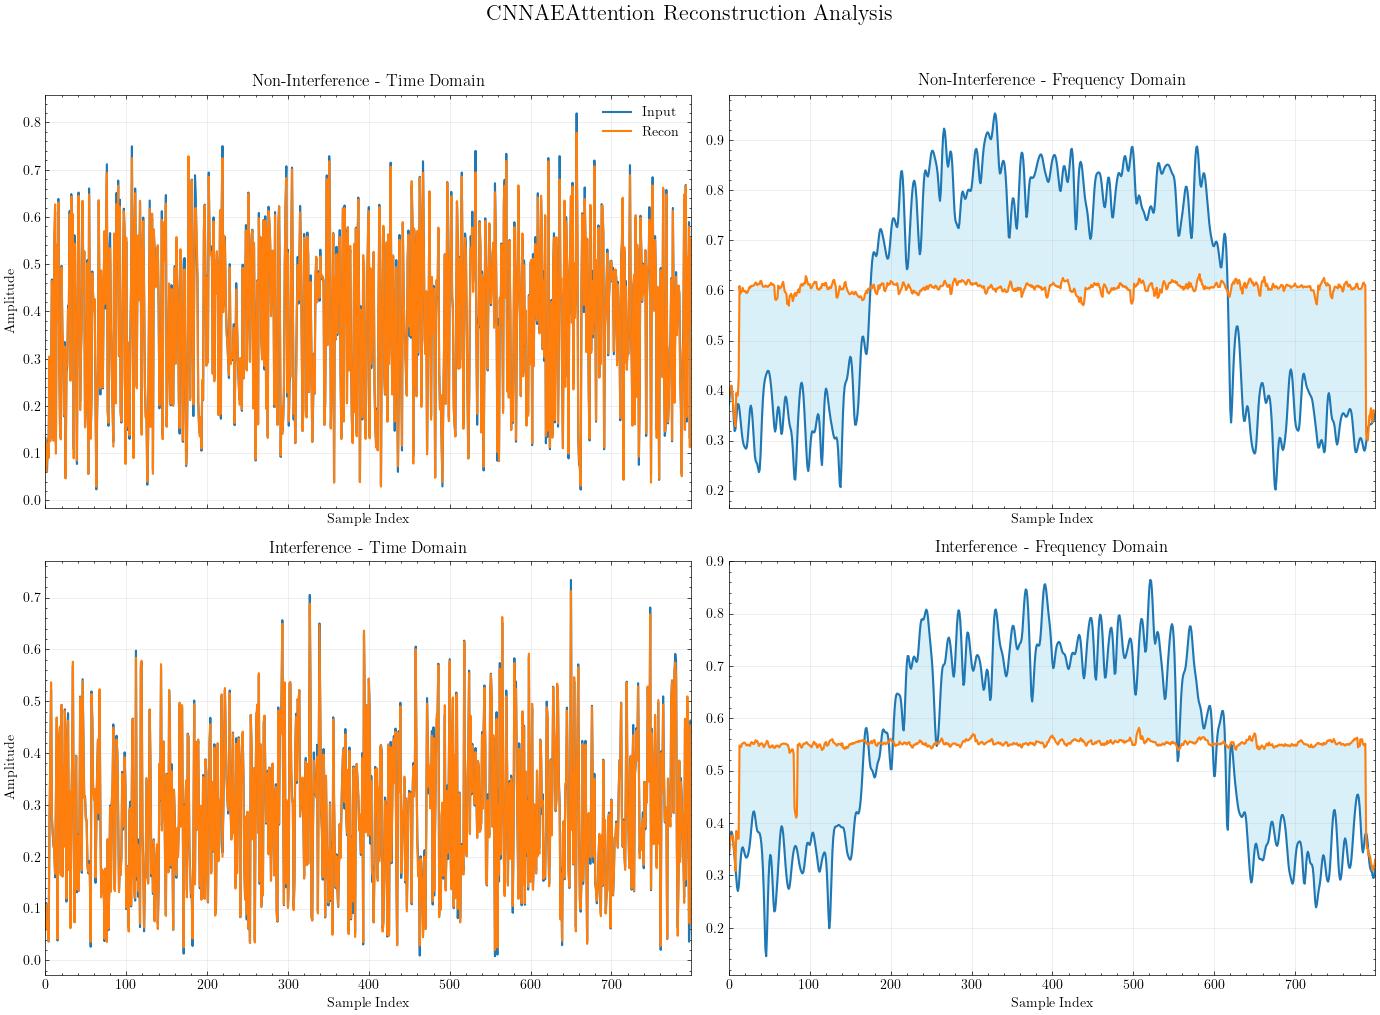

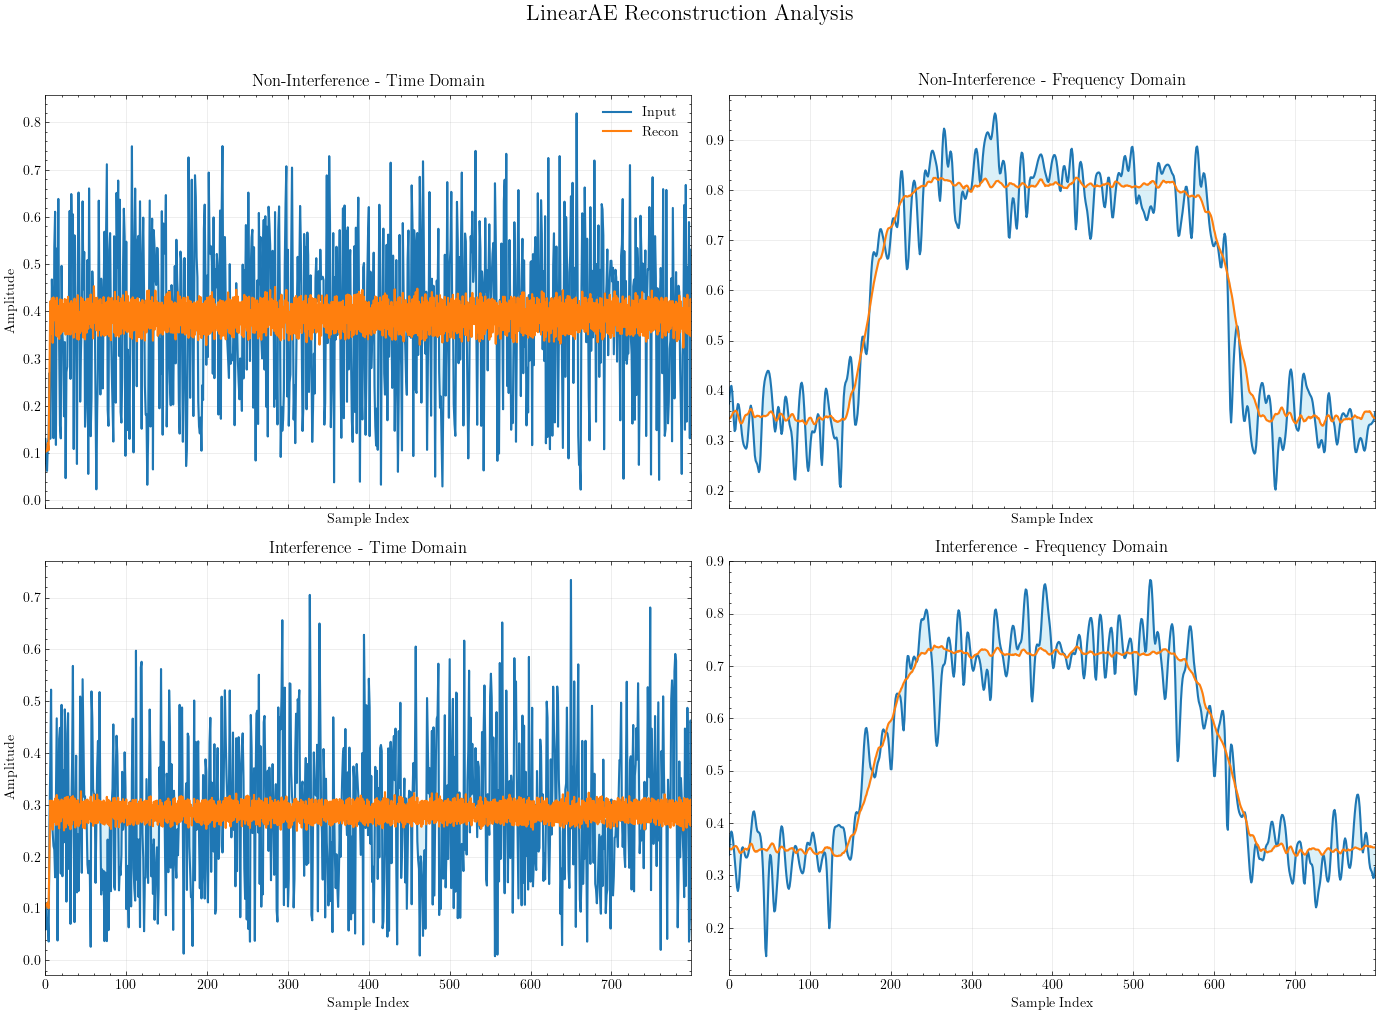

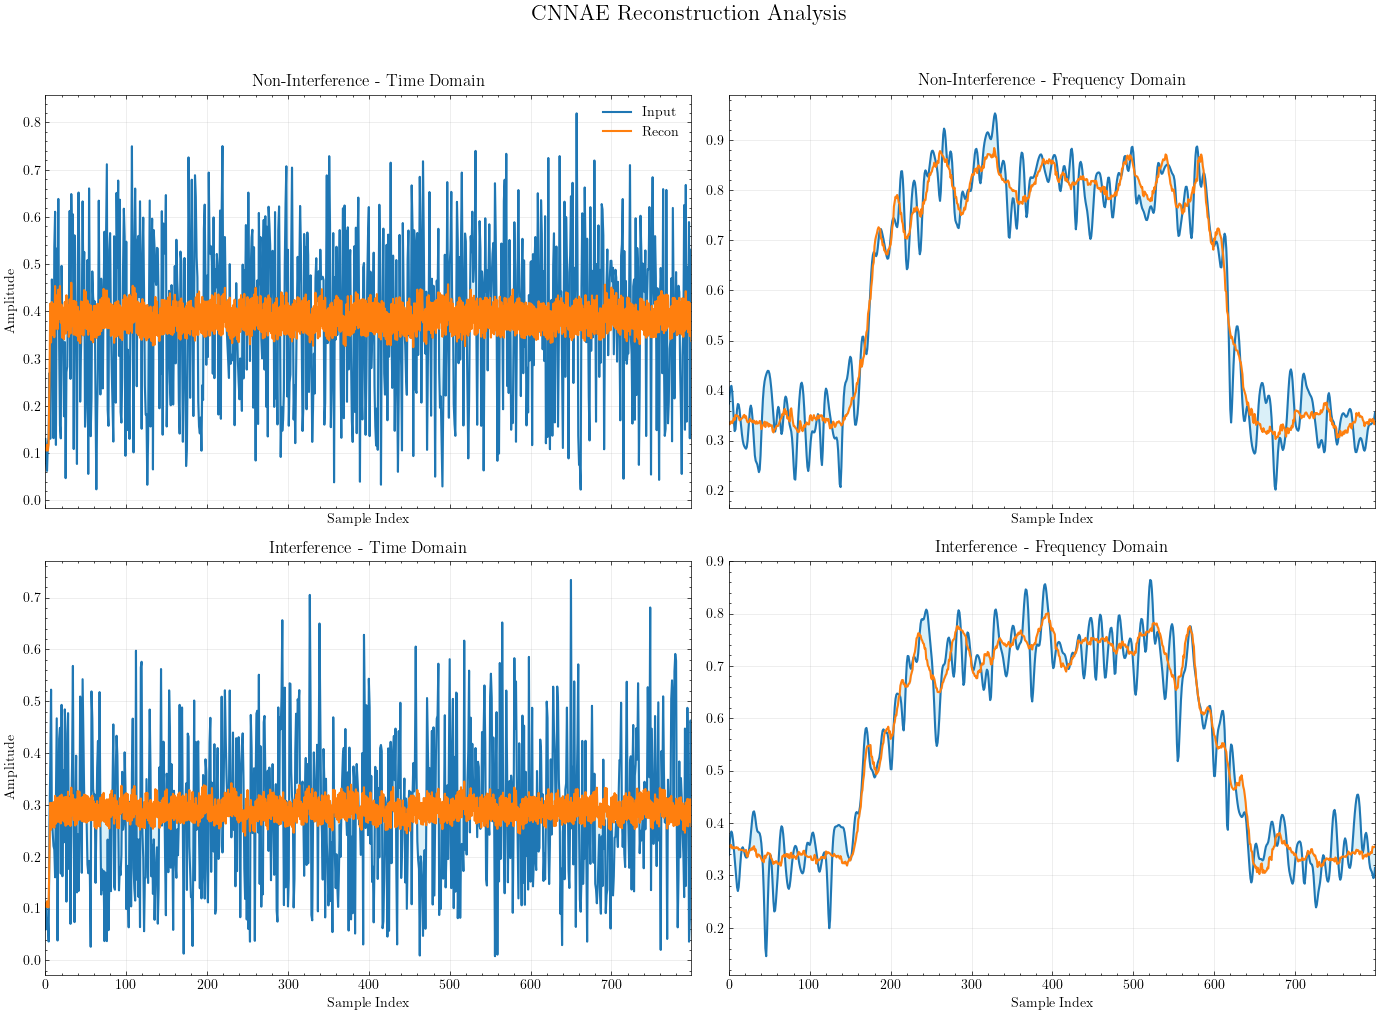

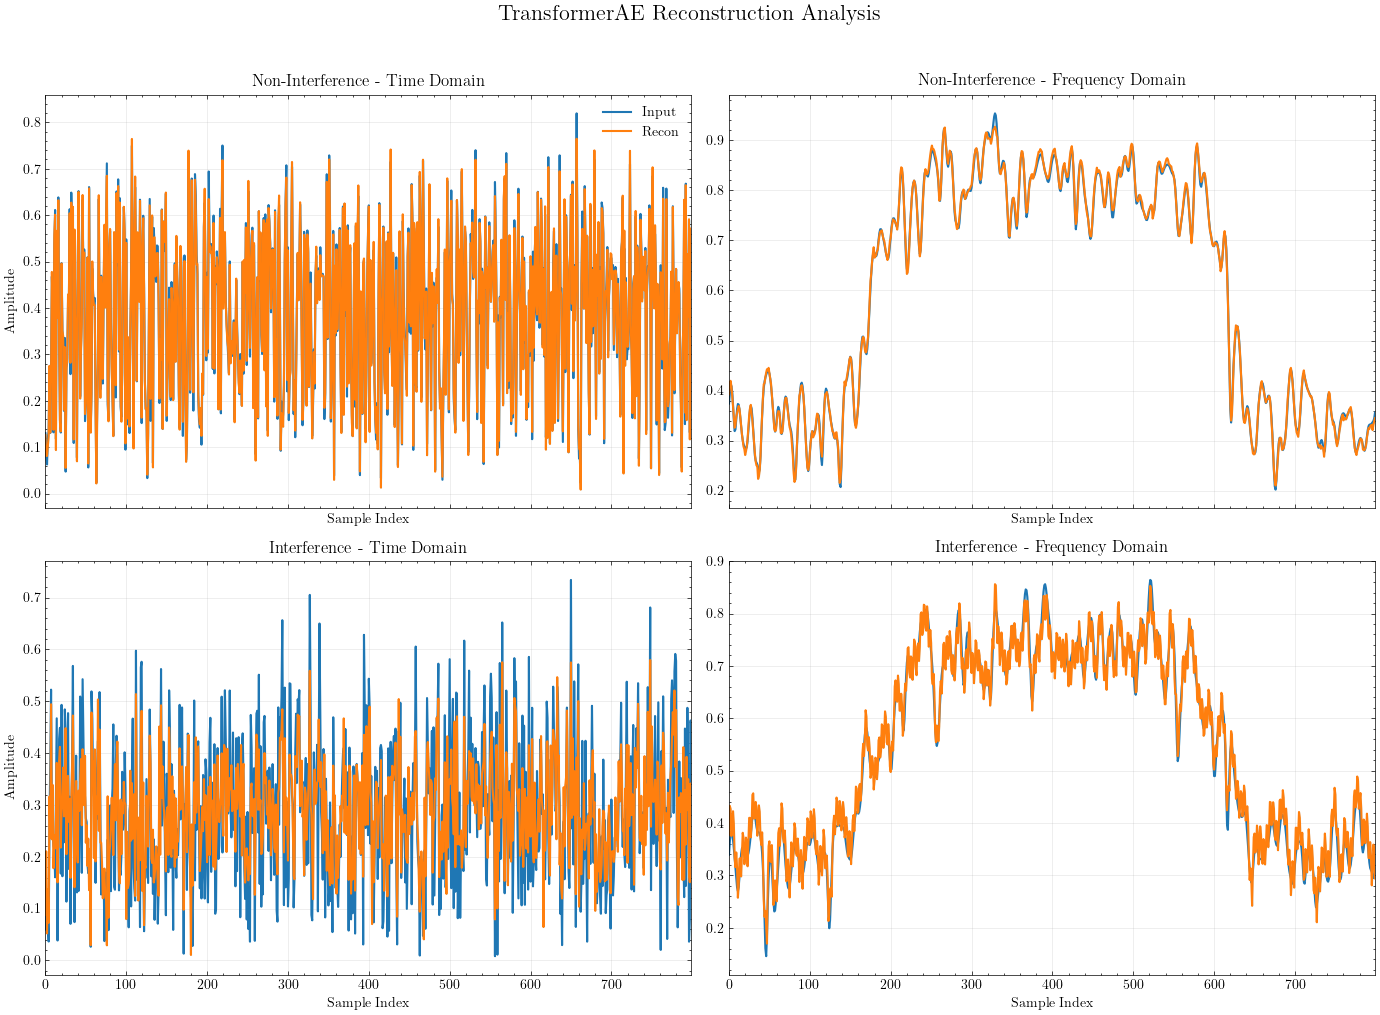

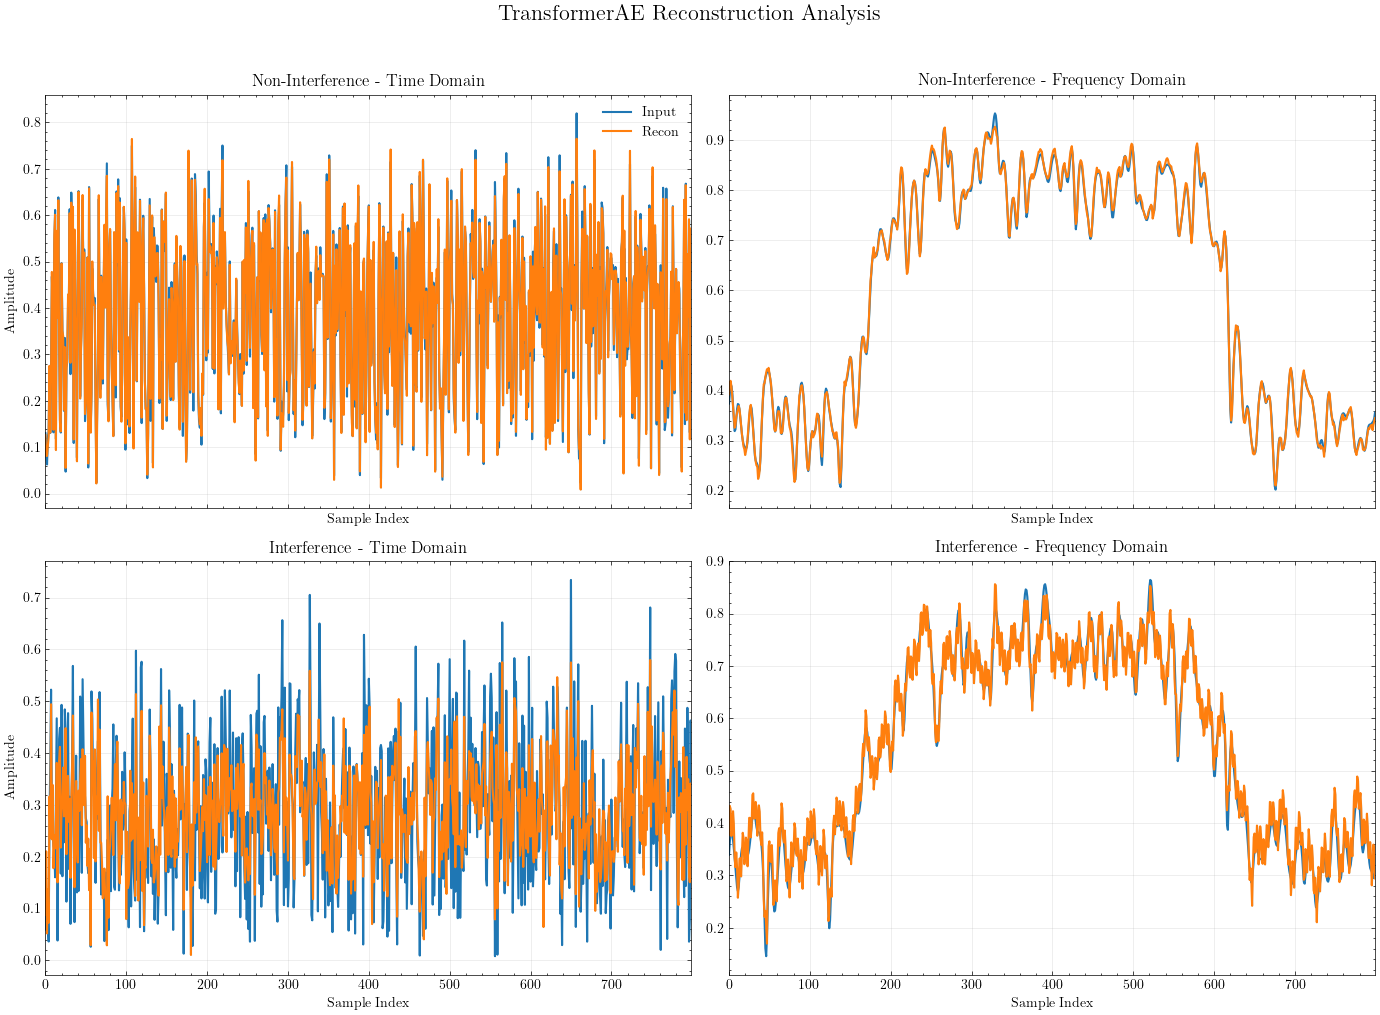

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle


def plot_reconstructions(pkl_path, save_dir=None):
    """Visualize reconstruction results with shaded differences"""
    # Load data
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)

    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex='col')
    class_name = os.path.basename(pkl_path).replace('_recon.pkl', '')
    fig.suptitle(f'{class_name} Reconstruction Analysis', y=1.02, fontsize=16)

    # Plot configuration
    colors = {'input': '#1f77b4', 'output': '#ff7f0e', 'gap': 'skyblue'}
    lw = 1.5

    # Plot for label 0 (non-interference)
    for idx, label in enumerate([0, 1]):
        prefix = f'{label}_'
        x = np.arange(len(data[f'{prefix}time_in']))

        # Time domain plot
        axs[idx, 0].plot(x, data[f'{prefix}time_in'],
                         color=colors['input'], lw=lw, label='Input')
        axs[idx, 0].plot(x, data[f'{prefix}time_out'],
                         color=colors['output'], lw=lw, label='Recon')
        axs[idx, 0].fill_between(x,
                                 data[f'{prefix}time_in'],
                                 data[f'{prefix}time_out'],
                                 color=colors['gap'], alpha=0.3)

        # Frequency domain plot
        axs[idx, 1].plot(x, data[f'{prefix}freq_in'],
                         color=colors['input'], lw=lw, label='Input')
        axs[idx, 1].plot(x, data[f'{prefix}freq_out'],
                         color=colors['output'], lw=lw, label='Recon')
        axs[idx, 1].fill_between(x,
                                 data[f'{prefix}freq_in'],
                                 data[f'{prefix}freq_out'],
                                 color=colors['gap'], alpha=0.3)

    # Formatting
    for axes_row, label_type in zip(axs, ['Non-Interference', 'Interference']):
        for ax, domain in zip(axes_row, ['Time Domain', 'Frequency Domain']):
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, len(x)-1)
            ax.set_title(f'{label_type} - {domain}')
            ax.set_xlabel('Sample Index')

    # axs[0, 0].legend(loc='upper right', framealpha=0.9)
    axs[0, 0].legend()
    axs[0, 0].set_ylabel('Amplitude')
    axs[1, 0].set_ylabel('Amplitude')

    plt.tight_layout()

    # Save or show
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f'{class_name}_recon.pdf'),
                    bbox_inches='tight', dpi=600)
    else:
        plt.show()


# Usage example
for model_class, run_name, file_name in models:
    class_name = model_class.__name__
    pkl_path = f'results/{class_name}_recon.pkl'

    if os.path.exists(pkl_path):
        plot_reconstructions(pkl_path, save_dir='doc/images/recon_plots')